In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt 
from PIL import Image
import random

In [2]:
class red_hopfield:

    def __init__(self, cantidad_neuronas = 10):
        # clase red de Hopfield
        # la cantidad de neuronas es un entero
        # pesos es una matriz cuadrada del tamaño de cantidad de neuronas x cantidad de neuronas
        self.cantidad_neuronas = cantidad_neuronas
        self.pesos = np.zeros([self.cantidad_neuronas, self.cantidad_neuronas])

    def _mi_sgn(self, a):
        # metodo de signo
        signo = 1
        if a < 0:
            signo = -1
        
        return signo
    
    def entrenar_red(self, patrones, tasa_aprendizaje=0.5):
        # metodo que realiza el ajuste de los pesos de la red
        for patron in patrones:
            patron = patron.reshape(-1, 1)
            self.pesos += tasa_aprendizaje*patron @ patron.T

        np.fill_diagonal(self.pesos, 0)
                    

    def predecir(self, entrada, steps=3000):
        # metodo de actualizacion asincronica  
        # se copia el patron de entrada para no modificarlo
        estado = np.copy(entrada)

        # se realiza un arreglo de indices para äctualizar las neuronas
        indices = np.linspace(0, self.cantidad_neuronas-1, self.cantidad_neuronas)

        for _ in range(steps):
            indices = np.random.permutation(indices)
            for indice in indices:
                hi = self.pesos[int(indice)] @ estado
                estado[int(indice)] = self._mi_sgn(hi) 

        return estado

    def predecir_sync(self, entrada, steps=10):
        # método de actualización sincronica de las neuronas
        estado = np.copy(entrada)

        for _ in range(steps):
            hi = self.pesos @ estado
            for i in range(self.cantidad_neuronas):
                estado[i] = self._mi_sgn(hi[i])

        return estado

    def imagen_a_patron(self, ruta):
        # metodp de transformacion de imagenes a patron
        imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)

        dimension_origianl = imagen.shape
        
        _, binarizada_img = cv2.threshold(imagen, 128, 255, cv2.THRESH_BINARY)
        
        binarizacion = np.where(binarizada_img == 255, 1, -1)

        patron = binarizacion.flatten()
        patron_relleno = np.pad(patron, (0, self.cantidad_neuronas - patron.size), 'constant', constant_values=-1)

        return patron_relleno, dimension_origianl, imagen

    @staticmethod
    def patron_a_imagen(patron, dimension_original):
        # Recortar el patrón a la forma original
        patron_redimensionado = patron[:dimension_original[0] * dimension_original[1]].reshape(dimension_original)
        
        # Convertimos los valores +1, -1 a escala de grises 0-255 para que pueda guardarse como imagen
        img_array = np.where(patron_redimensionado == 1, 255, 0).astype(np.uint8)
        
        return img_array
    
    def capacidad(self, pmax):
        # Divide la cantidad de patrones por la cantidad de neuronas
        return pmax/self.cantidad_neuronas

    def contar_errores(self, patron, test):
        # cuenta los valores no nulos
        errores = np.count_nonzero(patron - test)
        return errores

    def calc_error(self, m, errores_totales):
        # calcura el valor de error dividiendo la cantidad de errores totales por el producto entre 
        # la cantidad de neuronas y la cantidad de patrones
        return errores_totales/(self.cantidad_neuronas * m)
    
    def limpiar_pesos(self):
        # limpia la matriz de pesos 
        self.pesos = np.zeros([self.cantidad_neuronas, self.cantidad_neuronas])

    def crear_patrones_aleatorios(self, n, p=0.5):
        # metodo que crea patrones aleatorios a partir de una binomial
        patrones = []
        for _ in range(n):
            patron =  np.random.binomial(1, 0.5, self.cantidad_neuronas)
            patron = patron*2 - 1
            patrones.append(patron)
        return patrones
    
    def generar_patron_correlacionados(self, patron_base, correlacion):
        # Metodo que genera un nuevo patrón que tiene una correlación específica con el patrón base.
        
        num_flips = int((1 - correlacion) * self.cantidad_neuronas / 2)
        
        patron_nuevo = np.copy(patron_base)
        
        flip_indices = random.sample(range(self.cantidad_neuronas), num_flips)
        
        # Cambiar los bits seleccionados
        for indice in flip_indices:
            patron_nuevo[0][indice] *= -1
        
        return patron_nuevo
    
    def calcular_correlacion(patron1, patron2):
        # Metodo que calcula la correlacion de los patrones
        return np.dot(patron1, patron2) / len(patron1)

    
def borrar_porcentaje_imagen(input_image_path, output_image_path, porcentaje, color_borrar=0):
    """
    Borra un porcentaje de la imagen que se traduce en una cantidad de bits a modificar
    """ 
    img = Image.open(input_image_path)
    pixels = img.load()

    width, height = img.size
    total_pixeles = width * height


    pixeles_a_borrar = int(total_pixeles * (porcentaje / 100))

    coordenadas = [(x, y) for x in range(width) for y in range(height)]

    coordenadas_borrar = random.sample(coordenadas, pixeles_a_borrar)

    for coord in coordenadas_borrar:
        pixels[coord] = color_borrar

    img.save(output_image_path)


def sumar_imagenes_bn(output_image_path, *image_paths):
    """suma multiples imagenes bmp"""
    if len(image_paths) < 2:
        raise ValueError("Debes proporcionar al menos dos imágenes para sumar")

    img_suma = Image.open(image_paths[0]).convert('L')
    pixels_suma = img_suma.load()

    for image_path in image_paths[1:]:
        img = Image.open(image_path).convert('L')
        if img.size != img_suma.size:
            raise ValueError("Todas las imágenes deben tener el mismo tamaño")

        pixels_img = img.load()

        for x in range(img.width):
            for y in range(img.height):
                suma_actual = pixels_suma[x, y]
                val_img = pixels_img[x, y]

                suma = min(suma_actual + val_img, 255)

                pixels_suma[x, y] = suma

    img_suma.save(output_image_path)


borrar_porcentaje_imagen("imagenes_50_50\\panda.bmp", "panda_25.bmp", 25)
borrar_porcentaje_imagen("imagenes_50_50\\panda.bmp", "panda_50.bmp", 50)
borrar_porcentaje_imagen("imagenes_50_50\\panda.bmp", "panda_75.bmp", 75)

borrar_porcentaje_imagen("imagenes_45_60\\paloma.bmp", "paloma_25.bmp", 25)
borrar_porcentaje_imagen("imagenes_45_60\\paloma.bmp", "paloma_50.bmp", 50)
borrar_porcentaje_imagen("imagenes_45_60\\paloma.bmp", "paloma_75.bmp", 75)

sumar_imagenes_bn('imagen_suma.bmp', 'imagenes_50_50\\perro.bmp', 'imagenes_50_50\\v.bmp', 'imagenes_50_50\\panda.bmp')

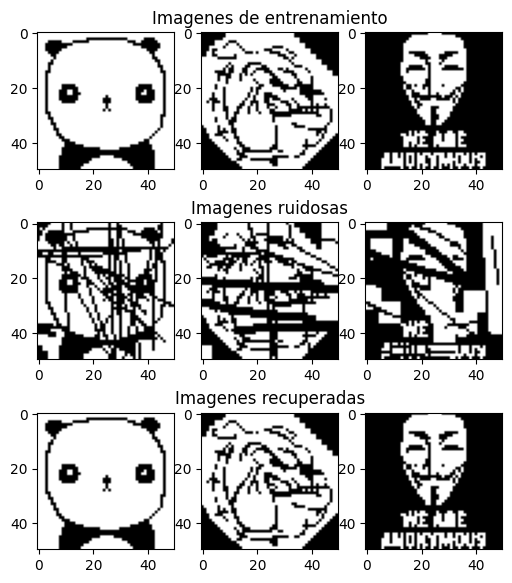

In [3]:
# Primer red implementada
red = red_hopfield((50*50))

carpeta = "imagenes_50_50"
carpeta_prueba = "50_50_ruidosas"

archivos = os.listdir(carpeta)
pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []

# Obtengo patrones de las imagenes para entrenamiento
for imagen in archivos:
    if ".bmp" in imagen:
        patron, dimension, imagen_entrenamiento = red.imagen_a_patron(f"imagenes_50_50\\{imagen}")
        patrones.append(patron)
        dimensiones.append(dimension)
        imagenes_entrenamiento.append(imagen_entrenamiento)
        
red.entrenar_red(patrones=patrones, tasa_aprendizaje=0.5)

# Obtengo patrones de evaluacion
for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1


# Realizo graficos 

fig, axs = plt.subplots(3, 3, figsize=(6,7))

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')

axs[1, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[1, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[1, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[2, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[2, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[2, 2].imshow(imagenes_recuperadas[2], cmap='gray')



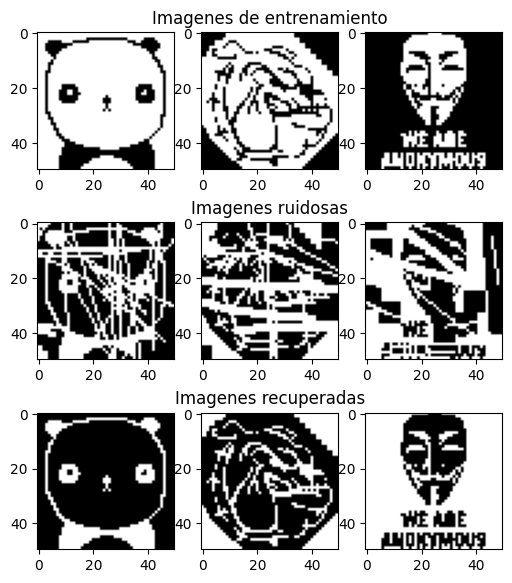

In [4]:
nuevos_recuperados = []
ruido_inverso = []
iter = 0

# Evaluo para estados espurios inversos
for patron in patrones_ruidosos:
    patron = -1*patron
    nuevo = red.predecir(patron, 20)
    ruido = red_hopfield.patron_a_imagen(patron, dimensiones_ruidosas[iter])
    nueva_imagen = red_hopfield.patron_a_imagen(nuevo, dimensiones_ruidosas[iter])
    ruido_inverso.append(ruido)
    nuevos_recuperados.append(nueva_imagen)
    iter += 1


fig, axs = plt.subplots(3, 3, figsize=(6,7))

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')

axs[1, 0].imshow(ruido_inverso[0], cmap='gray')
axs[1, 1].imshow(ruido_inverso[1], cmap='gray')
axs[1, 2].imshow(ruido_inverso[2], cmap='gray')

axs[2, 0].imshow(nuevos_recuperados[0], cmap='gray')
axs[2, 1].imshow(nuevos_recuperados[1], cmap='gray')
axs[2, 2].imshow(nuevos_recuperados[2], cmap='gray')



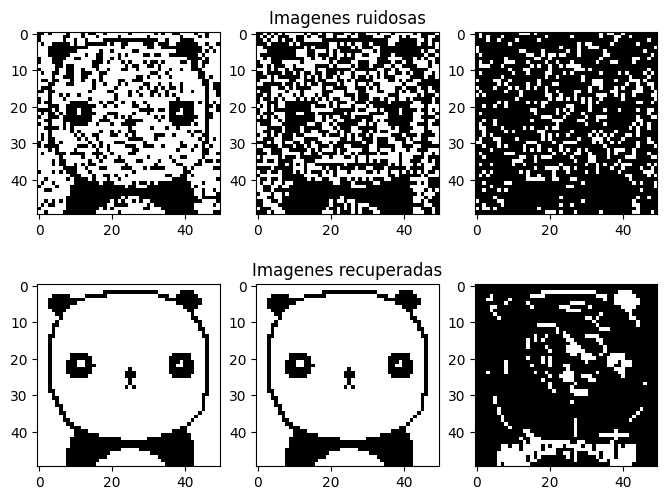

In [5]:
carpeta_prueba = "panda_ruidoso_porcentual"

pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []

# obtengo los patrones de las imagenes con ruido porcentual
for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1
    
# Realizo graficos
fig, axs = plt.subplots(2, 3, figsize=(8,6))

axs[0, 1].set_title("Imagenes ruidosas")
axs[1, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[0, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[0, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[1, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[1, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[1, 2].imshow(imagenes_recuperadas[2], cmap='gray')


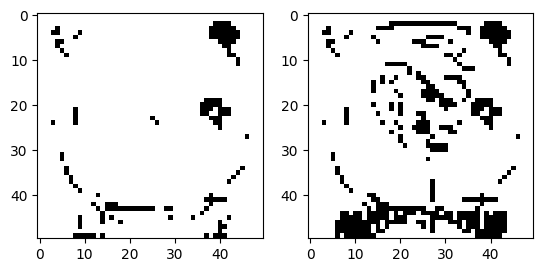

In [6]:
# Evaluo combinacion lineal de patrones
patron, dimension, imagen_= red.imagen_a_patron("imagen_suma.bmp")

patron_recuperado = red.predecir(patron, 70)
imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimension)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(imagen_, cmap='gray')
axs[1].imshow(imagen, cmap='gray')

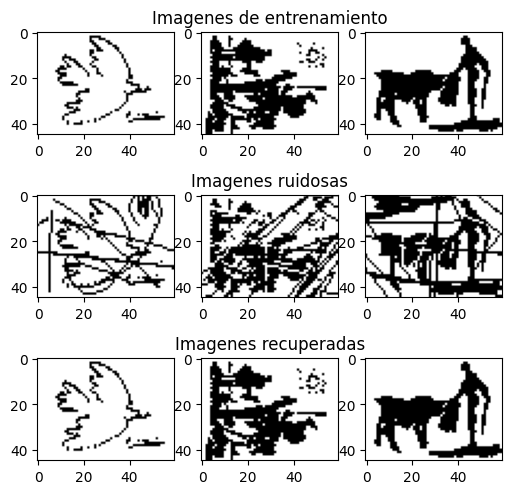

In [7]:
# Segunda red implementada

red2 = red_hopfield(45*60)

carpeta = "imagenes_45_60"
carpeta_prueba = "45_60_ruidosas"

archivos = os.listdir(carpeta)
pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []

# obtengo las imagenes de entrenamiento del segundo set
for imagen in archivos:
    if ".bmp" in imagen:
        patron, dimension, imagen_entrenamiento = red2.imagen_a_patron(f"{carpeta}\\{imagen}")
        patrones.append(patron)
        dimensiones.append(dimension)
        imagenes_entrenamiento.append(imagen_entrenamiento)
        
red2.entrenar_red(patrones=patrones, tasa_aprendizaje=0.5)

# Obtengo patrones de evaluacion 
for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red2.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red2.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

# Realizo graficos
fig, axs = plt.subplots(3, 3, figsize=(6,6))

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')

axs[1, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[1, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[1, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[2, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[2, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[2, 2].imshow(imagenes_recuperadas[2], cmap='gray')



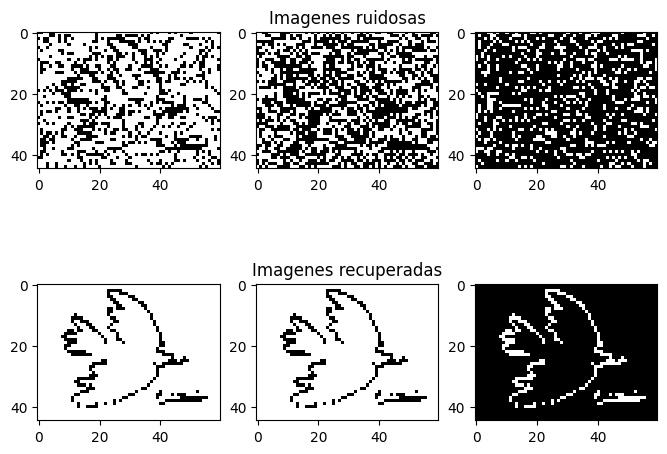

In [8]:
# Evaluacion del ruido porcentual en la red
carpeta_prueba = "paloma_ruido_porcentual"

pruebas = os.listdir(carpeta_prueba)

patrones = []
dimensiones = []
patrones_recuperados = []

patrones_ruidosos = []
dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []
        
for prueba in pruebas:
    if "bmp" in prueba:
        patron, dimension, imagen_ruidosa = red2.imagen_a_patron(f"{carpeta_prueba}\\{prueba}")
        patrones_ruidosos.append(patron)
        dimensiones_ruidosas.append(dimension)
        imagenes_ruidosas.append(imagen_ruidosa)

iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red2.predecir(patron, 20)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

# Realizo graficos
fig, axs = plt.subplots(2, 3, figsize=(8,6))

axs[0, 1].set_title("Imagenes ruidosas")
axs[1, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[0, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[0, 2].imshow(imagenes_ruidosas[2], cmap='gray')

axs[1, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[1, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[1, 2].imshow(imagenes_recuperadas[2], cmap='gray')



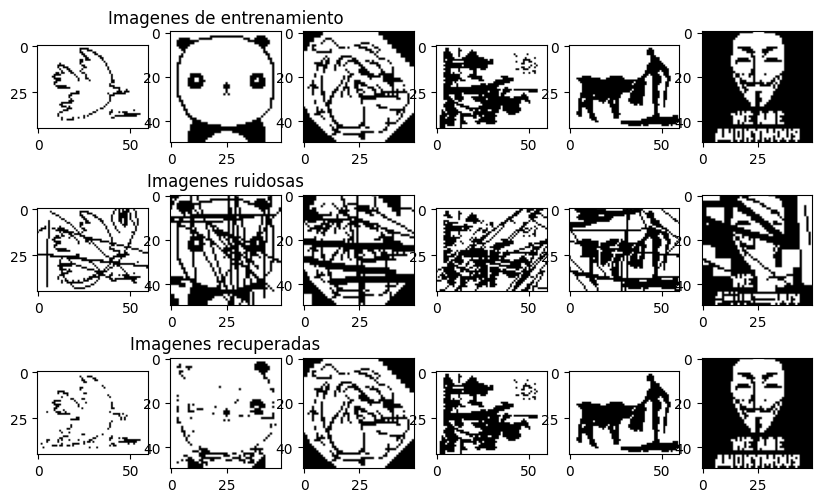

In [9]:
# Tercera red implementada
red3 = red_hopfield(45*60)

carpeta_6 = 'imagenes'
carpeta_de_test = 'imagenes_ruidosas'

archivos = os.listdir(carpeta_6)
pruebas = os.listdir(carpeta_de_test)

patrones = []
patrones_ruidosos = []
patrones_recuperados = []

dimensiones_ruidosas = []

imagenes_entrenamiento = []
imagenes_ruidosas = []
imagenes_recuperadas = []

# Obtengo imagenes de entrenamiento para la tercer red
for imagen in archivos:
    patron, dimension, imagen = red3.imagen_a_patron(f"{carpeta_6}\\{imagen}")
    patrones.append(patron)
    imagenes_entrenamiento.append(imagen)

red3.entrenar_red(patrones)

# Obtengo los patrones de evaluacion
for imagen in pruebas:
    patron, dimension, imagen = red3.imagen_a_patron(f"{carpeta_de_test}\\{imagen}")
    patrones_ruidosos.append(patron)
    dimensiones_ruidosas.append(dimension)
    imagenes_ruidosas.append(imagen)

# Evaluo la red
iter = 0
for patron in patrones_ruidosos:
    patron_recuperado = red3.predecir(patron, 30)
    imagen = red_hopfield.patron_a_imagen(patron_recuperado, dimensiones_ruidosas[iter])
    imagenes_recuperadas.append(imagen)
    iter += 1

# realizo graficos
fig, axs = plt.subplots(3, 6, figsize=(10,6))

axs[0, 1].set_title("Imagenes de entrenamiento")
axs[1, 1].set_title("Imagenes ruidosas")
axs[2, 1].set_title("Imagenes recuperadas")

axs[0, 0].imshow(imagenes_entrenamiento[0], cmap='gray')
axs[0, 1].imshow(imagenes_entrenamiento[1], cmap='gray')
axs[0, 2].imshow(imagenes_entrenamiento[2], cmap='gray')
axs[0, 3].imshow(imagenes_entrenamiento[3], cmap='gray')
axs[0, 4].imshow(imagenes_entrenamiento[4], cmap='gray')
axs[0, 5].imshow(imagenes_entrenamiento[5], cmap='gray')

axs[1, 0].imshow(imagenes_ruidosas[0], cmap='gray')
axs[1, 1].imshow(imagenes_ruidosas[1], cmap='gray')
axs[1, 2].imshow(imagenes_ruidosas[2], cmap='gray')
axs[1, 3].imshow(imagenes_ruidosas[3], cmap='gray')
axs[1, 4].imshow(imagenes_ruidosas[4], cmap='gray')
axs[1, 5].imshow(imagenes_ruidosas[5], cmap='gray')

axs[2, 0].imshow(imagenes_recuperadas[0], cmap='gray')
axs[2, 1].imshow(imagenes_recuperadas[1], cmap='gray')
axs[2, 2].imshow(imagenes_recuperadas[2], cmap='gray')
axs[2, 3].imshow(imagenes_recuperadas[3], cmap='gray')
axs[2, 4].imshow(imagenes_recuperadas[4], cmap='gray')
axs[2, 5].imshow(imagenes_recuperadas[5], cmap='gray')



In [10]:
# Analisis estadistico de la capacidad de la red

p_error = [0.001, 0.0036, 0.01, 0.05, 0.1]
pmax_N = [0.105, 0.138, 0.185, 0.37, 0.61]

N = 500

capacidad = 0
capacidades = []
red_ej2 = red_hopfield(N)
patrones = []
pmaxs = []
error = 0
errores = 0

# itero sobre las cotas de error 
for cota in p_error:
    while error < cota :
        patron = red_ej2.crear_patrones_aleatorios(1)
        patrones.append(patron)
        red_ej2.entrenar_red(patron)
        for patron_aprendido in patrones:
            # realizo una unica evaluacion sincronica
            patron_test = red_ej2.predecir_sync(np.squeeze(patron_aprendido), 1)
            errores_por_patron = red_ej2.contar_errores(patron_test, patron_aprendido)
            errores += errores_por_patron
        error = red_ej2.calc_error(len(patrones), errores)
        errores = 0

    # obtengo valor de capacidad para cada cota
    capacidad = red_ej2.capacidad(len(patrones))
    pmaxs.append(len(patrones))
    capacidades.append(capacidad)


capacidades, pmaxs

([0.104, 0.138, 0.184, 0.358, 0.61], [52, 69, 92, 179, 305])

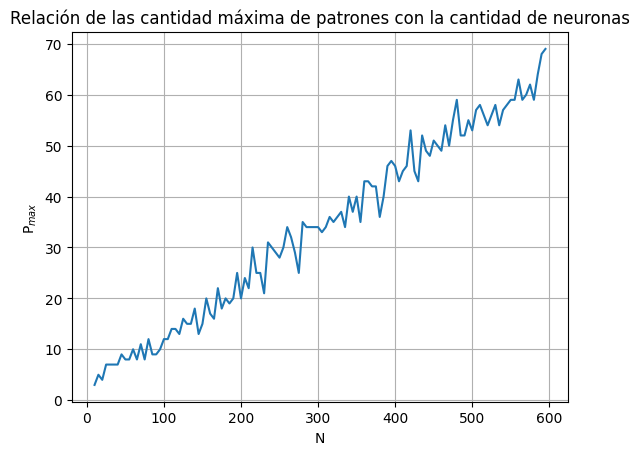

In [11]:
# Evaluo variacion de los patrones con el tamaño de la red
N = 500

capacidad = 0
capacidades = []

pmaxs = []

errores = 0
cant_neuronas = []

# Realizo barrido de cantidad de neuronas
for n in range(10, 600, 5):
    error = 0
    patrones = []
    cant_neuronas.append(n)
    red_ej2_2 = red_hopfield(n)

    # utilizo una sola cota de error
    while error < 0.001 :
      
        patron = red_ej2_2.crear_patrones_aleatorios(1)
        patrones.append(patron)
        red_ej2_2.entrenar_red(patron)
        for patron_aprendido in patrones:
            patron_test = red_ej2_2.predecir_sync(np.squeeze(patron_aprendido), 1)
            errores_por_patron = red_ej2_2.contar_errores(patron_test, patron_aprendido)
            errores += errores_por_patron
        error = red_ej2_2.calc_error(len(patrones), errores)
        errores = 0

    pmaxs.append(len(patrones))


plt.grid()

plt.title('Relación de las cantidad máxima de patrones con la cantidad de neuronas')

plt.xlabel('N')
plt.ylabel(r'$\text{P}_{max}$')

plt.plot(cant_neuronas, pmaxs)
plt.show()


In [12]:
# Realizo analisis estadistico sobre la variacion de la capacidad con la correlacion
N = 500 

red_ej2_3 = red_hopfield(N)

errores = 0

corrs_por_error = []
capacidades_por_error = []

# genero patron base del que se crearan el resto de patrones
patron_base = red_ej2_3.crear_patrones_aleatorios(1)

# Evaluo para las distintas cotas
for cota in p_error:
    corrs = []
    capacidades = []
    pmaxs = []
    for corr in range(1, 80, 5):
        
        error = 0
        patrones = [patron_base]
        red_ej2_3.limpiar_pesos()               # limpio la matriz de pesos para reiniciar la red para cada correlacion distinta
        red_ej2_3.entrenar_red(patron_base)

        while error < cota:
            
            patron = red_ej2_3.generar_patron_correlacionados(patron_base, corr/100)
            patrones.append(patron)
            red_ej2_3.entrenar_red(patron)
            for patron_aprendido in patrones:
                patron_test = red_ej2_3.predecir_sync(np.squeeze(patron_aprendido), 1)
                errores_por_patron = red_ej2_3.contar_errores(patron_test, patron_aprendido)
                errores += errores_por_patron
            error = red_ej2_3.calc_error(len(patrones), errores)
            errores = 0

        capacidad = red_ej2_3.capacidad(len(patrones))
        pmaxs.append(len(patrones))
        capacidades.append(capacidad)
        corrs.append(corr/100)
        
    # obtengo los valores de correlacion para cada cota y las capacidades correspondientes
    corrs_por_error.append(corrs)
    capacidades_por_error.append(capacidades)


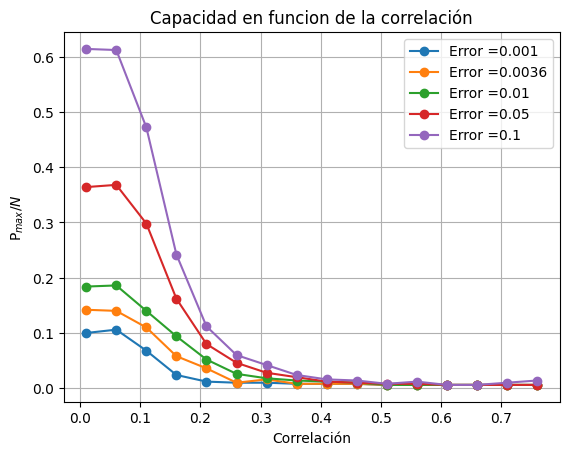

In [13]:
plt.grid()

plt.xlabel('Correlación')
plt.ylabel(r'$\text{P}_{max}/N$')

for i in range(5):
    plt.plot(corrs_por_error[i], capacidades_por_error[i], '-o', label=f"Error ={p_error[i]}")

plt.title("Capacidad en funcion de la correlación")
plt.legend()
plt.show()